размер датасета: (1121442, 3)
колонки: ['audio_path', 'text_path', 'duration']
всего записей: 1,121,442
пропущенные значения:
audio_path    3
text_path     3
duration      3
dtype: int64
count    1.121439e+06
mean     6.755528e+00
std      6.727824e+00
min      3.200000e-01
25%      2.740000e+00
50%      4.960000e+00
75%      7.900000e+00
max      1.256000e+02
Name: duration, dtype: float64


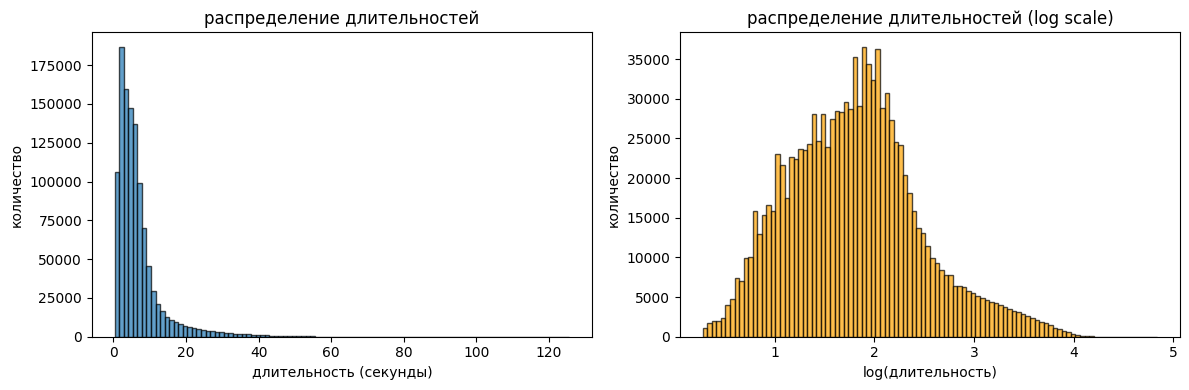


 =================== анализ структуры данных ===================
dataset_type
radio_2          651645
radio-v4         380157
public_speech     85003
radio_v4_add       4634
Name: count, dtype: int64

 =================== проверка доступности файлов =================== 


проверка файлов: 100%|██████████| 100/100 [00:00<00:00, 2886.39it/s]


аудио файлы: 48.0% доступно
текст файлы: 48.0% доступно

 =================== предобраотка текста =================== 


загрузка текстов: 100%|██████████| 1000/1000 [00:00<00:00, 1716.79it/s]


средняя длина текста: 110.9 символов
медианная длина текста: 71.0 символов
примеры текстов:
'де факто в...'
'статистике если на твои митинги ходят ну не на твои личные а на митинги оппозиции ходит максимум сем...'
'ле хорошо вот еще вопрос по поводу двенадцать июня спрашивают вас а вы считаете его праздничным днем...'


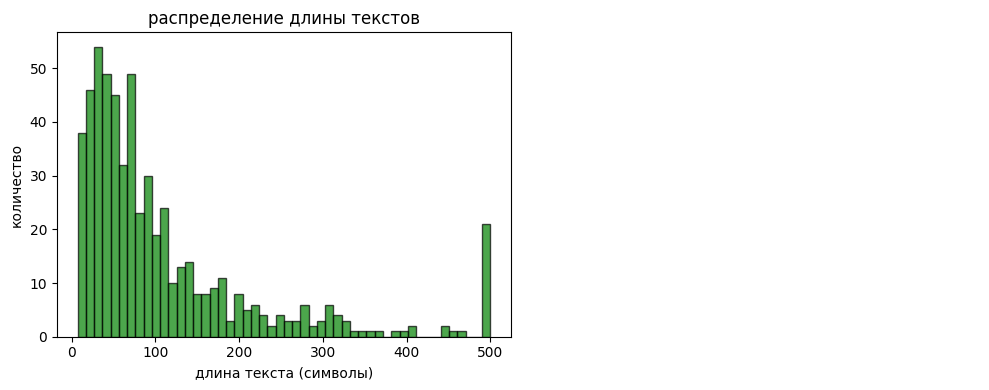

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm

"""
Работу выполнил:
Студент 4 курса бакалавриата ЧОУ МУИВ
группы ИСс 23.1/Б3-22
Кириллов Григорий Михайлович


Блок кода отвечающий за анализ и предобработку данных 
двух датасетов radio speech. 


"""

df = pd.read_csv('combined_dataset.csv')
print(f"размер датасета: {df.shape}")
print(f"колонки: {df.columns.tolist()}")
print(f"всего записей: {len(df):,}")
print(f"пропущенные значения:")
print(df.isnull().sum())
print(df['duration'].describe())

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df['duration'], bins=100, alpha=0.7, edgecolor='black')
plt.title('распределение длительностей')
plt.xlabel('длительность (секунды)')
plt.ylabel('количество')

plt.subplot(1, 2, 2)
plt.hist(np.log1p(df['duration']), bins=100, alpha=0.7, edgecolor='black', color='orange')
plt.title('распределение длительностей (log scale)')
plt.xlabel('log(длительность)')
plt.ylabel('количество')

plt.tight_layout()
plt.show()

print("\n =================== анализ структуры данных ===================")
df['dataset_type'] = df['audio_path'].str.split('/').str[0]
print(df['dataset_type'].value_counts())

print("\n =================== проверка доступности файлов =================== ")
def check_files_existence(df, sample_size=100):
    audio_exists = []
    text_exists = []
    
    sample_indices = np.random.choice(len(df), size=min(sample_size, len(df)), replace=False)
    
    for idx in tqdm(sample_indices, desc="проверка файлов"):
        row = df.iloc[idx]
        audio_exists.append(os.path.exists(row['audio_path']))
        text_exists.append(os.path.exists(row['text_path']))
    
    audio_success = np.mean(audio_exists) * 100
    text_success = np.mean(text_exists) * 100
    
    print(f"аудио файлы: {audio_success:.1f}% доступно")
    print(f"текст файлы: {text_success:.1f}% доступно")
    
    return audio_success, text_success

audio_success, text_success = check_files_existence(df)

print("\n =================== предобраотка текста =================== ")

def load_text_sample(text_path):
    try:
        with open(text_path, 'r', encoding='utf-8') as f:
            return f.read().strip()
    except:
        return ""

sample_indices = np.random.choice(len(df), size=min(1000, len(df)), replace=False)
texts = []

for idx in tqdm(sample_indices, desc="загрузка текстов"):
    text_path = df.iloc[idx]['text_path']
    if os.path.exists(text_path):
        text = load_text_sample(text_path)
        texts.append(text)

text_lengths = [len(text) for text in texts if text]
print(f"средняя длина текста: {np.mean(text_lengths):.1f} символов")
print(f"медианная длина текста: {np.median(text_lengths):.1f} символов")

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(text_lengths, bins=50, alpha=0.7, edgecolor='black', color='green')
plt.title('распределение длины текстов')
plt.xlabel('длина текста (символы)')
plt.ylabel('количество')

plt.subplot(1, 2, 2)
print("примеры текстов:")
for i in range(min(3, len(texts))):
    print(f"'{texts[i][:100]}...'")

plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

def create_clean_dataset_v2(df, min_duration=6.0, max_duration=15.0):
    """
    Создаёт очищенную версию датасета, включающую ТОЛЬКО записи
    с длительностью от min_duration до max_duration секунд.
    
    """

    print(f"Исходный размер: {len(df):,} записей")
    
    clean_df = df.dropna().copy()
    print(f"После удаления пропусков: {len(clean_df):,} записей")
    
    duration_mask = (clean_df['duration'] >= min_duration) & (clean_df['duration'] <= max_duration)
    clean_df = clean_df[duration_mask]
    print(f"После фильтрации по длительности ({min_duration}–{max_duration} сек): {len(clean_df):,} записей")
    
    tqdm.pandas(desc="Проверка аудио файлов")
    clean_df['audio_exists'] = clean_df['audio_path'].progress_apply(os.path.exists)
    
    tqdm.pandas(desc="Проверка текстовых файлов")
    clean_df['text_exists'] = clean_df['text_path'].progress_apply(os.path.exists)
    
    file_mask = clean_df['audio_exists'] & clean_df['text_exists']
    clean_df = clean_df[file_mask]
    
    clean_df = clean_df.drop(['audio_exists', 'text_exists'], axis=1).reset_index(drop=True)
    
    print(f"После проверки доступности файлов: {len(clean_df):,} записей")
    
    print(f"\n{'='*60}")
    print(f"ОЧИЩЕННЫЙ ДАТАСЕТ (duration ∈ [{min_duration}, {max_duration}] сек)")
    print(f"Записей: {len(clean_df):,}")
    if len(clean_df) > 0:
        print(f"min duration: {clean_df['duration'].min():.2f} сек")
        print(f"max duration: {clean_df['duration'].max():.2f} сек")
        print(f"mean duration: {clean_df['duration'].mean():.2f} сек")
        print(f"median duration: {clean_df['duration'].median():.2f} сек")
        
        if 'dataset_type' not in clean_df.columns:
            clean_df['dataset_type'] = clean_df['audio_path'].str.split('/').str[0]
        print("\nРаспределение по источникам:")
        print(clean_df['dataset_type'].value_counts())
    
    return clean_df

def main():
    df = pd.read_csv('combined_dataset.csv')
    
    clean_df_v2 = create_clean_dataset_v2(df, min_duration=6.0, max_duration=15.0)
    
    output_path = 'clean_dataset_v2.csv'
    clean_df_v2.to_csv(output_path, index=False)
    print(f"\nСохранено: '{output_path}'")
    
    return clean_df_v2

# Запуск
if __name__ == "__main__":
    clean_df_v2 = main()

исходный размер: 1,121,442 записей
после удаления пропусков: 1,121,439 записей
после фильтрации по длительности (1.0-15.0сек): 995,794 записей


проверка текстовых файлов: 100%|██████████| 995794/995794 [00:02<00:00, 375655.86it/s]


После проверки файлов: 546,645 записей

=================== Результаты после очистки ===================
Сохранилось записей: 546,645 из 1,121,442 (48.7%)

распределение длительностей в очищенном датасете:
min: 1.00сек
max: 15.00сек
mean: 5.25сек
median: 4.26сек


загрузка текстов: 100%|██████████| 1000/1000 [00:00<00:00, 1554.50it/s]


средняя длина текста: 78.3 символов
медианная длина текста: 62.0 символов
min длина: 7 символов
max длина: 318 символов

примеры текстов:
  'которые мы не решаем мне кажется мы просто пудрим раны мы прекрасно решили проблему слишком большого...'
  'и что очевидно есть несколько центров которые курируют'
  'о конечно не одной и двух недель может занять несколько месяцев а может быть пару тройку лет но это ...'

датасет после очистки - 'clean_dataset.csv'


In [3]:
clean_df

,audio_path,text_path,duration
12609,radio_2/4/23/0d1516fb4430.opus,radio_2/4/23/0d1516fb4430.txt,1.0
12610,radio_2/9/25/ac57f738e670.opus,radio_2/9/25/ac57f738e670.txt,1.0
12611,radio_2/5/4c/79271620fdfa.opus,radio_2/5/4c/79271620fdfa.txt,1.0
12612,radio_2/d/57/3149939d8748.opus,radio_2/d/57/3149939d8748.txt,1.0
12613,radio_2/0/35/d8d6f0f017f3.opus,radio_2/0/35/d8d6f0f017f3.txt,1.0
...,...,...,...
559249,radio_2/8/56/9d96293b256e.opus,radio_2/8/56/9d96293b256e.txt,15.0
559250,radio_2/a/0f/65262934c4f7.opus,radio_2/a/0f/65262934c4f7.txt,15.0
559251,radio_2/b/fe/a3aaa4d47aba.opus,radio_2/b/fe/a3aaa4d47aba.txt,15.0
559252,radio_2/6/17/b34cd09698fd.opus,radio_2/6/17/b34cd09698fd.txt,15.0


In [3]:
from sklearn.model_selection import train_test_split

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math


In [5]:
def check_environment():

    """
    Блок кода отвечающий за проверку доступности GPU и ресурсов
    
    """

    print(f"PyTorch version: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    
    import psutil
    ram_gb = psutil.virtual_memory().total / 1024**3 # ОЗУ
    print(f"system RAM: {ram_gb:.1f} GB")
    
    disk_free = psutil.disk_usage('.').free / 1024**3 # диск
    print(f"free disk space: {disk_free:.1f} GB")


check_environment()

PyTorch version: 2.9.1+cu128
CUDA available: True
GPU: NVIDIA GeForce RTX 3060
GPU Memory: 11.6 GB
system RAM: 30.4 GB
free disk space: 705.5 GB


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import soundfile as sf  
import librosa  
from torch.utils.data import Dataset, DataLoader
from collections import Counter


In [8]:
import torch
import gc

"""
Блок кода отвечающий за очистку GPU от зомби процессов
может потребоваться при засорении памяти при обучении моделей
также можно просто перезапустить ядро, окружение, компьютер
либо воспользоваться командной строкой
"""

torch.cuda.empty_cache()
gc.collect()

if torch.cuda.is_available():
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

print(f"память после очистки: {torch.cuda.memory_allocated() / 1024**3:.2f} GB / {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

память после очистки: 0.00 GB / 0.00 GB


In [ ]:
class DeepSpeechVocabulary:
    def __init__(self):
        # алфавит: строчные буквы, пробел, цифры, пунктуация
        chars = [
            ' ', 'а', 'б', 'в', 'г', 'д', 'е', 'ё', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н',
            'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я',
            '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
            '!', '?', ',', '.', '-', ':', ';', '(', ')', '"', "'"
        ]
        
        # Blank всегда имеет индекс 0 (требование CTC)
        self.char_to_idx = {'<blank>': 0}
        for i, ch in enumerate(chars, start=1):
            self.char_to_idx[ch] = i
        
        self.idx_to_char = {v: k for k, v in self.char_to_idx.items()}
        self.vocab_size = len(self.char_to_idx)
        self.blank_id = 0
        
        print(f"DeepSpeech2 vocabulary создан: {self.vocab_size} токенов (включая blank)")

    def text_to_indices(self, text):
        """
        Преобразует текст в список индексов без blank.
        """
        indices = []
        for char in text.lower():
            if char in self.char_to_idx:
                indices.append(self.char_to_idx[char])
        return indices

    def indices_to_text(self, indices):
        """
        Преобразует список индексов (после CTC decoding) в текст.
        """
        text = []
        for idx in indices:
            if idx != self.blank_id and idx in self.idx_to_char:
                text.append(self.idx_to_char[idx])
        return ''.join(text)

In [ ]:
import os
import pandas as pd
import numpy as np
import soundfile as sf
import librosa
from tqdm import tqdm

SAMPLE_RATE = 16000
N_MELS = 80

def audio_to_mel_npy(audio_path, npy_path):
    try:
        audio, sr = sf.read(audio_path)
        if sr != SAMPLE_RATE:
            audio = librosa.resample(audio, orig_sr=sr, target_sr=SAMPLE_RATE)
        mel_spec = librosa.feature.melspectrogram(
            y=audio, sr=SAMPLE_RATE, n_mels=N_MELS, n_fft=512, hop_length=160
        )
        log_mel = librosa.power_to_db(mel_spec, ref=np.max)
        log_mel = (log_mel + 100) / 100.0
        np.save(npy_path, log_mel.astype(np.float32))
        return True
    except Exception as e:
        print(f"Ошибка: {audio_path} - {e}")
        return False

df = pd.read_csv('clean_dataset_v2.csv')
print(f"Обработка {len(df)} файлов")

for idx, row in tqdm(df.iterrows(), total=len(df)):
    opus_path = row['audio_path']
    if not os.path.exists(opus_path):
        continue
    npy_path = opus_path.replace('.opus', '.npy')
    if not os.path.exists(npy_path):
        os.makedirs(os.path.dirname(npy_path), exist_ok=True)
        audio_to_mel_npy(opus_path, npy_path)

print("Предобработка завершена")

In [ ]:
import os
import pandas as pd
import numpy as np
import soundfile as sf
import librosa
from tqdm import tqdm

SAMPLE_RATE = 16000
N_MELS = 80

def audio_to_mel_npy(audio_path, npy_path):
    try:
        audio, sr = sf.read(audio_path)
        if sr != SAMPLE_RATE:
            audio = librosa.resample(audio, orig_sr=sr, target_sr=SAMPLE_RATE)
        mel_spec = librosa.feature.melspectrogram(
            y=audio, sr=SAMPLE_RATE, n_mels=N_MELS, n_fft=512, hop_length=160
        )
        log_mel = librosa.power_to_db(mel_spec, ref=np.max)
        log_mel = (log_mel + 100) / 100.0
        np.save(npy_path, log_mel.astype(np.float32))
        return True
    except Exception as e:
        print(f"Ошибка: {audio_path} - {e}")
        return False

df = pd.read_csv('clean_dataset_v2.csv')
print(f"Обработка {len(df)} файлов")

for idx, row in tqdm(df.iterrows(), total=len(df)):
    opus_path = row['audio_path']
    if not os.path.exists(opus_path):
        continue
    npy_path = opus_path.replace('.opus', '.npy')
    if not os.path.exists(npy_path):
        os.makedirs(os.path.dirname(npy_path), exist_ok=True)
        audio_to_mel_npy(opus_path, npy_path)

df['audio_path'] = df['audio_path'].str.replace('.opus', '.npy')
df.to_csv('clean_dataset_v2_preprocessed.csv', index=False)

print("Предобработка завершена. Создан clean_dataset_v2_preprocessed.csv")

In [7]:
import torch
import torch.nn as nn
import numpy as np
import soundfile as sf
import librosa
from torch.utils.data import Dataset, DataLoader
import pandas as pd

"""
Блок кода отвечающий за создание dataloader для обучения моделей

"""

class RNNTVocabulary:
    def __init__(self):
        self.blank_token = '<blank>'
        self.sos_token = '<sos>'
        self.eos_token = '<eos>'
        self.unk_token = '<unk>'
        
        russian_letters = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'
        digits = '0123456789'
        punctuation = ' .,!?-;:"()\''
        
        all_chars = russian_letters + digits + punctuation
        
        self.char_to_idx = {
            self.blank_token: 0,
            self.sos_token: 1, 
            self.eos_token: 2,
            self.unk_token: 3
        }
        
        for i, char in enumerate(all_chars, start=4):
            self.char_to_idx[char] = i
        
        self.idx_to_char = {idx: char for char, idx in self.char_to_idx.items()}
        self.vocab_size = len(self.char_to_idx)
        
        print(f"RNN-vocabulary создан: {self.vocab_size} токенов")

    def text_to_indices(self, text):
        text = text.lower().strip()
        indices = [self.char_to_idx[self.sos_token]]
        for char in text:
            if char in self.char_to_idx:
                indices.append(self.char_to_idx[char])
            else:
                indices.append(self.char_to_idx[self.unk_token])
        indices.append(self.char_to_idx[self.eos_token])
        return indices
    
    def indices_to_text(self, indices):
        chars = []
        for idx in indices:
            if idx == self.char_to_idx[self.blank_token]:
                continue
            if idx == self.char_to_idx[self.eos_token]:
                break
            if idx == self.char_to_idx[self.sos_token]:
                continue
            chars.append(self.idx_to_char.get(idx, self.unk_token))
        return ''.join(chars)

class RNNTDataset(Dataset):
    def __init__(self, dataframe, vocabulary, sample_rate=16000, max_audio_length=3.5):
        self.dataframe = dataframe.reset_index(drop=True)
        self.vocab = vocabulary
        self.sample_rate = sample_rate
        self.max_audio_samples = int(max_audio_length * sample_rate)
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        try:
            row = self.dataframe.iloc[idx]
            
            audio, sr = sf.read(row['audio_path'])
            if sr != self.sample_rate:
                audio = librosa.resample(audio, orig_sr=sr, target_sr=self.sample_rate)
            
            # нормализация аудио
            audio = audio / (np.max(np.abs(audio)) + 1e-8) 
            
            # обрезка/дополнение до фиксированной длины
            if len(audio) > self.max_audio_samples: 
                audio = audio[:self.max_audio_samples]
            else:
                audio = np.pad(audio, (0, self.max_audio_samples - len(audio)))
            
            with open(row['text_path'], 'r', encoding='utf-8') as f:
                text = f.read().strip().lower()
            
            if len(text) < 2:
                return self.__getitem__((idx + 1) % len(self))
            
            return {
                'audio': torch.FloatTensor(audio),
                'text': text,
                'tokens': torch.LongTensor(self.vocab.text_to_indices(text)),
                'audio_length': min(len(audio), self.max_audio_samples),
                'text_length': len(text) + 2
            }
        except Exception as e:
            print(f"ошибка загрузки данных idx={idx}: {e}")

            return self.__getitem__((idx + 1) % len(self))

def rnnt_collate_fn(batch):
    audios = torch.stack([item['audio'] for item in batch])
    tokens = [item['tokens'] for item in batch]
    raw_texts = [item['text'] for item in batch]
    audio_lengths = torch.LongTensor([item['audio_length'] for item in batch])
    text_lengths = torch.LongTensor([len(item['tokens']) for item in batch])
    
    max_text_len = max(text_lengths)
    text_tensor = torch.zeros(len(batch), max_text_len, dtype=torch.long)
    for i, token_seq in enumerate(tokens):
        text_tensor[i, :len(token_seq)] = token_seq
    
    return {
        'audios': audios,
        'texts': text_tensor,
        'text_lengths': text_lengths,
        'audio_lengths': audio_lengths,
        'raw_texts': raw_texts
    }

def create_dataloaders(train_df, val_df, batch_size=32, max_audio_length=3.5):

    """
    Блок кода отвечающий за создание dataloader для обучения

    """
    
    vocab = RNNTVocabulary()
    
    train_dataset = RNNTDataset(train_df, vocab, max_audio_length=max_audio_length)
    val_dataset = RNNTDataset(val_df, vocab, max_audio_length=max_audio_length)
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True,
        num_workers=0,
        collate_fn=rnnt_collate_fn,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False, 
        num_workers=0,
        collate_fn=rnnt_collate_fn,
        pin_memory=True
    )
    
    print(f"DataLoader создан!")
    print(f"train: {len(train_loader)} батчей")
    print(f"val: {len(val_loader)} батчей")
    print(f"vocabulary size: {vocab.vocab_size}")
    
    return train_loader, val_loader, vocab

if __name__ == "__main__":

    clean_df = pd.read_csv('clean_dataset.csv')
    train_df = clean_df[:1000]  
    val_df = clean_df[1000:1200]
    
    print(f"данные: train={len(train_df)}, val={len(val_df)}")
    
    train_loader, val_loader, vocab = create_dataloaders(
        train_df, val_df, 
        batch_size=16, 
        max_audio_length=3.5
    )
    
    
    batch = next(iter(train_loader)) # Проверка одного батча
    print(f"аудио: {batch['audios'].shape}")
    print(f"тексты: {batch['texts'].shape}")
    print(f"длины аудио: {batch['audio_lengths'][:5]}")
    print(f"длины текстов: {batch['text_lengths'][:5]}")
    
    for i in range(2):
        original = batch['raw_texts'][i]
        tokens = batch['texts'][i]
        decoded = vocab.indices_to_text(tokens.tolist())
        print(f"оригинал: {original}")
        print(f"декодированный: {decoded}")
        print("=" * 55)

данные: train=1000, val=200
RNN-vocabulary создан: 59 токенов
DataLoader создан!
train: 63 батчей
val: 13 батчей
vocabulary size: 59
аудио: torch.Size([16, 56000])
тексты: torch.Size([16, 21])
длины аудио: tensor([56000, 56000, 56000, 56000, 56000])
длины текстов: tensor([18, 13, 20, 14, 17])
оригинал: тоянно проигрыва
декодированный: тоянно проигрыва
оригинал: о лет назад
декодированный: о лет назад


In [12]:
""" ========================  ГИБРИД 1 РАБОЧАЯЯ ======================== """

' ========================  ГИБРИД 1 РАБОЧАЯЯ ======================== '

устройство: cuda
размеры данных:
train: 163,993 samples
val: 2,000 samples
RNN-vocabulary создан: 59 токенов
параметры модели: 1,829,127
старт обучения
параметры 1,829,127

 epoch 1/12


Validation: 100%|██████████| 125/125 [00:32<00:00,  3.89it/s]


train Loss: 0.0003, val Loss: 0.0254
val CER: 59.66%, val char accuracy: 10.88%
learning rate: 2.95e-04
лучшая модель сохранена CER: 59.66%
oригинал:   ну тогда за это платили а сейчас за другое ниче
CTC:        тодазат поатилишасдбу
attention:  о такого закон потому что образования (Acc: 10.5%)
--------------------------------------------------
oригинал:   полнению больше всего похожа
CTC:        поненетатанабочесепоожат
attention:  о на это отношения в совершенно (Acc: 4.0%)
--------------------------------------------------
oригинал:   он вернется то не потому что ему так этого хочется
CTC:        ооненсенниктвшенотототоочетс
attention:  о воли не все не потому что то то то то то то то то то то то то то то то то то то то то то то то то  (Acc: 17.1%)
--------------------------------------------------

 epoch 2/12


Validation: 100%|██████████| 125/125 [00:28<00:00,  4.31it/s]


train Loss: 0.0002, val Loss: 0.0194
val CER: 47.22%, val char accuracy: 13.81%
learning rate: 2.80e-04
лучшая модель сохранена CER: 47.22%
oригинал:   ну тогда за это платили а сейчас за другое ниче
CTC:        тодазат плотиишасядругу
attention:  отого заявляет платили очень срубуе (Acc: 5.3%)
--------------------------------------------------
oригинал:   полнению больше всего похожа
CTC:        понене такано боше сепохожа
attention:  о не не такая вообще сегодня похожа (Acc: 8.0%)
--------------------------------------------------
oригинал:   он вернется то не потому что ему так этого хочется
CTC:        болоернесенанеттомушемотоэто этохоче
attention:  облам не освом не потому что это от это от этого хочет (Acc: 41.5%)
--------------------------------------------------

 epoch 3/12


Validation: 100%|██████████| 125/125 [00:28<00:00,  4.36it/s]


train Loss: 0.0002, val Loss: 0.0166
val CER: 41.02%, val char accuracy: 15.65%
learning rate: 2.56e-04
лучшая модель сохранена CER: 41.02%
oригинал:   ну тогда за это платили а сейчас за другое ниче
CTC:        отдазат плотиличеся друго
attention:  о отдазает платили очень обругую (Acc: 5.3%)
--------------------------------------------------
oригинал:   полнению больше всего похожа
CTC:        пол нени такано болше сео похожа
attention:  о не не такая на больше сегодня (Acc: 8.0%)
--------------------------------------------------
oригинал:   он вернется то не потому что ему так этого хочется
CTC:        боловернесянаниптомушемотоэто этохочетс
attention:  обларнен в совет на нет того что это охочется (Acc: 14.6%)
--------------------------------------------------

 epoch 4/12


Validation: 100%|██████████| 125/125 [00:29<00:00,  4.23it/s]


train Loss: 0.0002, val Loss: 0.0155
val CER: 38.62%, val char accuracy: 15.43%
learning rate: 2.25e-04
лучшая модель сохранена CER: 38.62%
oригинал:   ну тогда за это платили а сейчас за другое ниче
CTC:        отдазает плотилишесо другуа
attention:  потому что он платили ошистад гругое говори (Acc: 10.5%)
--------------------------------------------------
oригинал:   полнению больше всего похожа
CTC:        пол нене такаво больше сего похожа
attention:  полнение такая воборше всего похожа (Acc: 28.0%)
--------------------------------------------------
oригинал:   он вернется то не потому что ему так этого хочется
CTC:        бол влернеосяно неттому ше мыто этохочетс
attention:  полу в рернего все на нет того что ему так этого хочется (Acc: 9.8%)
--------------------------------------------------

 epoch 5/12


Validation: 100%|██████████| 125/125 [00:28<00:00,  4.36it/s]


train Loss: 0.0002, val Loss: 0.0149
val CER: 35.13%, val char accuracy: 18.10%
learning rate: 1.89e-04
лучшая модель сохранена CER: 35.13%
oригинал:   ну тогда за это платили а сейчас за другое ниче
CTC:        отдазает платири очеся другу
attention:  и одна заявит платили очень содругуе (Acc: 5.3%)
--------------------------------------------------
oригинал:   полнению больше всего похожа
CTC:        пол нене така о больше всео похожа
attention:  и не тека во больше всего похожа (Acc: 4.0%)
--------------------------------------------------
oригинал:   он вернется то не потому что ему так этого хочется
CTC:        бол верне сяна не потому же моток этохочетс
attention:  и будет вернется на непотому что мы так этого хочется (Acc: 0.0%)
--------------------------------------------------

 epoch 6/12


Validation: 100%|██████████| 125/125 [00:28<00:00,  4.39it/s]


train Loss: 0.0002, val Loss: 0.0136
val CER: 32.93%, val char accuracy: 18.37%
learning rate: 1.50e-04
лучшая модель сохранена CER: 32.93%
oригинал:   ну тогда за это платили а сейчас за другое ниче
CTC:        отда зает платили осечсо другу
attention:  и одно заявит платили очень остругует (Acc: 5.3%)
--------------------------------------------------
oригинал:   полнению больше всего похожа
CTC:        пол не неткоо больше все похожа
attention:  и не такая во больше все похожаю (Acc: 28.0%)
--------------------------------------------------
oригинал:   он вернется то не потому что ему так этого хочется
CTC:        бул верни всено непотому жемо тог этохочетс
attention:  и будем вернева все на непотому что ему так этого хочется (Acc: 4.9%)
--------------------------------------------------

 epoch 7/12


Validation: 100%|██████████| 125/125 [00:28<00:00,  4.38it/s]


train Loss: 0.0002, val Loss: 0.0138
val CER: 31.01%, val char accuracy: 18.77%
learning rate: 1.11e-04
лучшая модель сохранена CER: 31.01%
oригинал:   ну тогда за это платили а сейчас за другое ниче
CTC:        отда зат платири очечся другоя
attention:  отого за это платили очень остругу (Acc: 5.3%)
--------------------------------------------------
oригинал:   полнению больше всего похожа
CTC:        ол нение тако на больше всего похожа
attention:  о не такая во больше всего похожа (Acc: 12.0%)
--------------------------------------------------
oригинал:   он вернется то не потому что ему так этого хочется
CTC:        бол влернео сононепотомуше мотак этог хочетс
attention:  о более в рермев в совне потому что мы так этого хочет (Acc: 17.1%)
--------------------------------------------------

 epoch 8/12


Validation: 100%|██████████| 125/125 [00:29<00:00,  4.31it/s]


train Loss: 0.0002, val Loss: 0.0133
val CER: 30.27%, val char accuracy: 21.60%
learning rate: 7.50e-05
лучшая модель сохранена CER: 30.27%
oригинал:   ну тогда за это платили а сейчас за другое ниче
CTC:        отда зат платили осечасо другое
attention:  отому за это платили очень остругует (Acc: 5.3%)
--------------------------------------------------
oригинал:   полнению больше всего похожа
CTC:        пол не нетакона больше всего похожа
attention:  опулания не так она больше всего похожа (Acc: 8.0%)
--------------------------------------------------
oригинал:   он вернется то не потому что ему так этого хочется
CTC:        боло вернео сяно непотому ше мо так эт хочетс
attention:  об лерме от сознание потому что ему так этого хочет (Acc: 12.2%)
--------------------------------------------------

 epoch 9/12


Validation: 100%|██████████| 125/125 [00:28<00:00,  4.40it/s]


train Loss: 0.0002, val Loss: 0.0130
val CER: 29.80%, val char accuracy: 19.93%
learning rate: 4.39e-05
лучшая модель сохранена CER: 29.80%
oригинал:   ну тогда за это платили а сейчас за другое ниче
CTC:        отда зат платили осечася другу
attention:  и одна заявит платили очень остадовое (Acc: 5.3%)
--------------------------------------------------
oригинал:   полнению больше всего похожа
CTC:        пал не нетакана больше всего похожа
attention:  и на такая во больше всего похожа (Acc: 12.0%)
--------------------------------------------------
oригинал:   он вернется то не потому что ему так этого хочется
CTC:        боло вернио всяно непотомуше мотк этогхочетс
attention:  и буду вернева все на непотому что ему так этого хочет (Acc: 9.8%)
--------------------------------------------------

 epoch 10/12


Validation: 100%|██████████| 125/125 [00:28<00:00,  4.38it/s]


train Loss: 0.0002, val Loss: 0.0130
val CER: 28.64%, val char accuracy: 19.78%
learning rate: 2.01e-05
лучшая модель сохранена CER: 28.64%
oригинал:   ну тогда за это платили а сейчас за другое ниче
CTC:        отода зат платири осечася другу
attention:  и так одазатель платили о сейчас одругое (Acc: 26.3%)
--------------------------------------------------
oригинал:   полнению больше всего похожа
CTC:        пол не не тако ва больше всего похожа
attention:  и он не так она больше всего похожа (Acc: 16.0%)
--------------------------------------------------
oригинал:   он вернется то не потому что ему так этого хочется
CTC:        бул вернео всяно непотому ше мо так этогхочетс
attention:  и буду в рернем все на непотому что мы так этого хочет (Acc: 12.2%)
--------------------------------------------------

 epoch 11/12


Validation: 100%|██████████| 125/125 [00:28<00:00,  4.36it/s]


train Loss: 0.0002, val Loss: 0.0127
val CER: 28.57%, val char accuracy: 19.94%
learning rate: 5.11e-06
лучшая модель сохранена CER: 28.57%
oригинал:   ну тогда за это платили а сейчас за другое ниче
CTC:        отода зат платири осечася другуе
attention:  и одна заявит платили особрого (Acc: 5.3%)
--------------------------------------------------
oригинал:   полнению больше всего похожа
CTC:        пол не нетако на больше всего похожа
attention:  и он не такая набольше всего похожа (Acc: 16.0%)
--------------------------------------------------
oригинал:   он вернется то не потому что ему так этого хочется
CTC:        було вернео всоно непотому ше мо так этохочетс
attention:  и буду вернева в совне потому что ему так этого хочет (Acc: 7.3%)
--------------------------------------------------

 epoch 12/12


Validation: 100%|██████████| 125/125 [00:29<00:00,  4.31it/s]


train Loss: 0.0002, val Loss: 0.0127
val CER: 28.05%, val char accuracy: 20.44%
learning rate: 0.00e+00
лучшая модель сохранена CER: 28.05%
oригинал:   ну тогда за это платили а сейчас за другое ниче
CTC:        отда зат платири осечася другуе
attention:  и одна заявит платили о сейчас одругое (Acc: 5.3%)
--------------------------------------------------
oригинал:   полнению больше всего похожа
CTC:        ол не неакона больше всего похожа
attention:  и на тека во больше всего похожа (Acc: 4.0%)
--------------------------------------------------
oригинал:   он вернется то не потому что ему так этого хочется
CTC:        бул вернео всоно непотому ше мо так это хочетс
attention:  и буду вернева в совне потому что ему так этого хочет (Acc: 7.3%)
--------------------------------------------------
модель сохранена


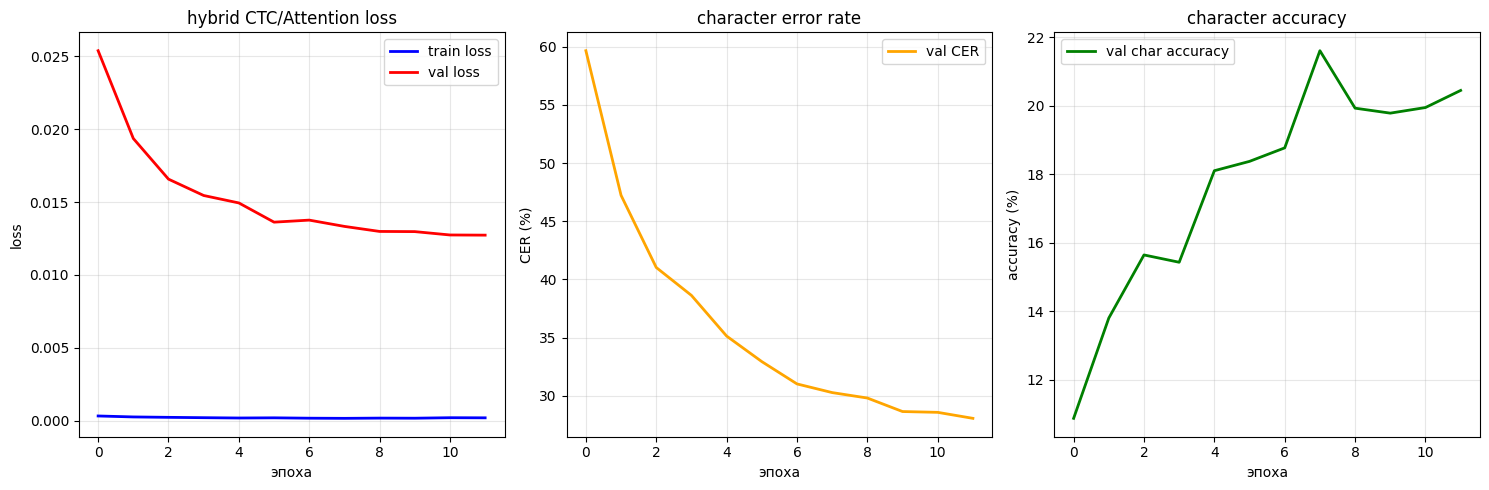

обучение завершено!
лучший val loss: 0.0127
лучший val CER: 28.05%
character accuracy: 20.44%


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import soundfile as sf
import librosa
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pandas as pd

class HybridConfig:
    SAMPLE_RATE = 16000
    MAX_AUDIO_LENGTH = 3.5
    TRAIN_FRACTION = 0.3  
    
    # encoder
    AUDIO_DIM = 80
    ENCODER_HIDDEN_DIM = 192  
    ENCODER_LAYERS = 3
    
    # decoder  
    DECODER_HIDDEN_DIM = 192
    DECODER_LAYERS = 2
    ATTENTION_DIM = 128
    
    # training
    BATCH_SIZE = 16
    NUM_EPOCHS = 15  
    LEARNING_RATE = 8e-4  
    DROPOUT = 0.5  
    WEIGHT_DECAY = 1e-4 
    
    CTC_WEIGHT = 0.4  
    ATTENTION_WEIGHT = 0.6

config = HybridConfig()

class HybridAudioEncoder(nn.Module):
    def __init__(self, input_dim=1, feature_dim=80, hidden_dim=192):
        super().__init__()
        
        self.conv_blocks = nn.Sequential(
            nn.Conv1d(input_dim, 64, kernel_size=10, stride=5, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Conv1d(64, 96, kernel_size=8, stride=4, padding=2),
            nn.BatchNorm1d(96),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Conv1d(96, feature_dim, kernel_size=5, stride=4, padding=1),
            nn.BatchNorm1d(feature_dim),
            nn.ReLU(),
        )
        
        self.pool = nn.AvgPool1d(kernel_size=2, stride=2)
        self.projection = nn.Linear(feature_dim, hidden_dim)
        
    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(1)
        
        x = self.conv_blocks(x)
        x = self.pool(x)
        x = x.transpose(1, 2)
        x = self.projection(x)
        return x

class HybridEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=3, dropout=0.2):
        super().__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=False
        )
        
    def forward(self, x):
        x, _ = self.lstm(x)
        return x

class BahdanauAttention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim=128):
        super().__init__()
        self.W = nn.Linear(encoder_dim, attention_dim)
        self.U = nn.Linear(decoder_dim, attention_dim)
        self.v = nn.Linear(attention_dim, 1)
        
    def forward(self, decoder_hidden, encoder_outputs):
        decoder_hidden = decoder_hidden.unsqueeze(1)
        scores = self.v(torch.tanh(
            self.W(encoder_outputs) + self.U(decoder_hidden)
        ))
        
        attn_weights = F.softmax(scores, dim=1)
        context = torch.sum(attn_weights * encoder_outputs, dim=1)
        
        return context, attn_weights.squeeze(-1)

class AttentionDecoder(nn.Module):
    def __init__(self, vocab_size, encoder_dim, decoder_dim, num_layers=2, dropout=0.2):
        super().__init__()
        self.vocab_size = vocab_size
        self.decoder_dim = decoder_dim
        
        self.embedding = nn.Embedding(vocab_size, decoder_dim, padding_idx=0)
        self.attention = BahdanauAttention(encoder_dim, decoder_dim)
        
        self.lstm = nn.LSTM(
            input_size=decoder_dim + encoder_dim,
            hidden_size=decoder_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        
        self.output_layer = nn.Linear(decoder_dim + encoder_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, encoder_outputs, targets=None, max_length=100):
        batch_size = encoder_outputs.size(0)
        
        hidden = None
        input_token = torch.full((batch_size,), 1, device=encoder_outputs.device)
        outputs = []
        
        if targets is not None:
            for t in range(targets.size(1) - 1):
                output, hidden = self._step(input_token, hidden, encoder_outputs)
                outputs.append(output)
                input_token = targets[:, t + 1]
        else:
            for t in range(max_length):
                output, hidden = self._step(input_token, hidden, encoder_outputs)
                outputs.append(output)
                
                input_token = torch.argmax(output, dim=-1)
                if (input_token == 2).all():
                    break
        
        return torch.stack(outputs, dim=1)
    
    def _step(self, input_token, hidden, encoder_outputs):
        embedded = self.embedding(input_token)
        
        if hidden is None:
            context = torch.zeros(encoder_outputs.size(0), encoder_outputs.size(2), 
                                device=encoder_outputs.device)
        else:
            decoder_hidden = hidden[0][-1]
            context, _ = self.attention(decoder_hidden, encoder_outputs)
        
        lstm_input = torch.cat([embedded, context], dim=-1).unsqueeze(1)
        lstm_out, hidden = self.lstm(lstm_input, hidden)
        lstm_out = lstm_out.squeeze(1)
        
        output_input = torch.cat([lstm_out, context], dim=-1)
        output = self.output_layer(output_input)
        
        return output, hidden

class HybridCTCAttention(nn.Module):
    def __init__(self, config, vocab_size):
        super().__init__()
        self.config = config
        self.vocab_size = vocab_size
        
        self.audio_encoder = HybridAudioEncoder(
            input_dim=1, 
            feature_dim=config.AUDIO_DIM,
            hidden_dim=config.ENCODER_HIDDEN_DIM
        )
        
        self.encoder = HybridEncoder(
            input_dim=config.ENCODER_HIDDEN_DIM,
            hidden_dim=config.ENCODER_HIDDEN_DIM,
            num_layers=config.ENCODER_LAYERS,
            dropout=config.DROPOUT
        )
        
        self.ctc_head = nn.Linear(config.ENCODER_HIDDEN_DIM, vocab_size)
        self.attention_decoder = AttentionDecoder(
            vocab_size=vocab_size,
            encoder_dim=config.ENCODER_HIDDEN_DIM,
            decoder_dim=config.DECODER_HIDDEN_DIM,
            num_layers=config.DECODER_LAYERS,
            dropout=config.DROPOUT
        )
        
    def forward(self, audio_input, text_input=None):
        audio_features = self.audio_encoder(audio_input)
        encoder_out = self.encoder(audio_features)
        
        ctc_logits = self.ctc_head(encoder_out)
        
        if text_input is not None:
            attn_logits = self.attention_decoder(encoder_out, text_input)
            return ctc_logits, attn_logits, encoder_out.size(1)
        else:
            return ctc_logits
    
    def decode(self, audio_input, method='attention', max_length=100):
        self.eval()
        with torch.no_grad():
            audio_features = self.audio_encoder(audio_input)
            encoder_out = self.encoder(audio_features)
            
            if method == 'ctc':
                ctc_logits = self.ctc_head(encoder_out)
                ctc_probs = F.softmax(ctc_logits, dim=-1)
                predictions = torch.argmax(ctc_probs, dim=-1)
                
                decoded = []
                for seq in predictions:
                    chars = []
                    prev_char = None
                    for char_idx in seq:
                        char_idx = char_idx.item()
                        if char_idx != 0 and char_idx != prev_char:
                            if char_idx != 2:
                                chars.append(char_idx)
                        prev_char = char_idx
                    decoded.append(chars)
                return decoded
                
            else:
                attn_logits = self.attention_decoder(encoder_out, max_length=max_length)
                predictions = torch.argmax(attn_logits, dim=-1)
                return [seq.tolist() for seq in predictions]

class HybridLoss(nn.Module):
    def __init__(self, ctc_weight=0.4, blank=0):
        super().__init__()
        self.ctc_weight = ctc_weight
        self.attention_weight = 1.0 - ctc_weight
        self.blank = blank
        
    def forward(self, ctc_logits, attn_logits, targets, input_lengths, target_lengths):
        ctc_log_probs = F.log_softmax(ctc_logits, dim=-1)
        
        max_input_len = ctc_log_probs.size(1)
        input_lengths = torch.clamp(input_lengths, max=max_input_len)
        
        ctc_loss = F.ctc_loss(
            ctc_log_probs.transpose(0, 1),
            targets,
            input_lengths,
            target_lengths,
            blank=self.blank,
            zero_infinity=True
        )
        
        attn_loss = F.cross_entropy(
            attn_logits.reshape(-1, attn_logits.size(-1)),
            targets[:, 1:].reshape(-1),
            ignore_index=0
        )
        
        total_loss = (self.ctc_weight * ctc_loss + 
                     self.attention_weight * attn_loss)
        
        return total_loss, ctc_loss, attn_loss

class HybridTrainer:
    def __init__(self, model, vocab, device):
        self.model = model
        self.vocab = vocab
        self.device = device
        self.best_val_loss = float('inf')
        self.best_val_cer = 100.0
        
    def train(self, train_loader, val_loader, num_epochs=12, lr=3e-4):
        optimizer = optim.AdamW(  
            self.model.parameters(), 
            lr=lr,
            weight_decay=config.WEIGHT_DECAY
        )
        
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)  
        loss_fn = HybridLoss(ctc_weight=config.CTC_WEIGHT)
        
        train_losses, val_losses, val_cers, val_accs = [], [], [], []
        
        print("старт обучения")
        print(f"параметры {sum(p.numel() for p in self.model.parameters()):,}")
        
        for epoch in range(num_epochs):
            print(f"\n epoch {epoch+1}/{num_epochs}")
            print("=" * 55)
            
            train_loss = self._train_epoch(optimizer, loss_fn, train_loader)
            train_losses.append(train_loss)
            
            val_loss, val_cer, val_acc = self._validate_epoch(loss_fn, val_loader)
            val_losses.append(val_loss)
            val_cers.append(val_cer)
            val_accs.append(val_acc)
            
            scheduler.step()
            
            print(f"train Loss: {train_loss:.4f}, val Loss: {val_loss:.4f}")
            print(f"val CER: {val_cer:.2f}%, val char accuracy: {val_acc:.2f}%")
            print(f"learning rate: {scheduler.get_last_lr()[0]:.2e}")
            
            if val_cer < self.best_val_cer:
                self.best_val_cer = val_cer
                self.best_val_loss = val_loss
                torch.save(self.model.state_dict(), 'best_hybrid_model1.pth')
                print(f"лучшая модель сохранена CER: {val_cer:.2f}%")
            
            self._test_decoding(val_loader)
        
        return train_losses, val_losses, val_cers, val_accs
    
    def _train_epoch(self, optimizer, loss_fn, dataloader):
        self.model.train()
        total_loss = 0
        
        progress_bar = tqdm(dataloader, desc="training")
        for batch_idx, batch in enumerate(progress_bar):
            audios = batch['audios'].to(self.device, non_blocking=True)
            texts = batch['texts'].to(self.device, non_blocking=True)
            text_lengths = batch['text_lengths'].to(self.device, non_blocking=True)
            audio_lengths = batch['audio_lengths'].to(self.device, non_blocking=True)
            
            optimizer.zero_grad()
            
            ctc_logits, attn_logits, seq_len = self.model(audios, texts)
            ctc_input_lengths = self._calculate_ctc_lengths(audio_lengths, seq_len)
            
            total_loss, ctc_loss, attn_loss = loss_fn(
                ctc_logits, attn_logits, texts, ctc_input_lengths, text_lengths
            )
            
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 0.5)
            optimizer.step()
            
            total_loss += total_loss.item()
            
            if batch_idx % 50 == 0:
                progress_bar.set_postfix({
                    'loss': f'{total_loss.item():.4f}',
                    'ctc': f'{ctc_loss.item():.4f}',
                    'attn': f'{attn_loss.item():.4f}',
                    'avg': f'{total_loss/(batch_idx+1):.4f}'
                })
        
        return total_loss / len(dataloader)
    
    def _calculate_ctc_lengths(self, audio_lengths, seq_len):
        compression_factor = 160
        ctc_lengths = (audio_lengths / compression_factor).long()
        ctc_lengths = torch.clamp(ctc_lengths, max=seq_len)
        return ctc_lengths
    
    def _validate_epoch(self, loss_fn, dataloader):
        self.model.eval()
        total_loss = 0
        total_cer = 0
        total_char_accuracy = 0
        total_samples = 0
        
        with torch.no_grad():
            for batch in tqdm(dataloader, desc="Validation"):
                audios = batch['audios'].to(self.device)
                texts = batch['texts'].to(self.device)
                text_lengths = batch['text_lengths'].to(self.device)
                audio_lengths = batch['audio_lengths'].to(self.device)
                
                ctc_logits, attn_logits, seq_len = self.model(audios, texts)
                ctc_input_lengths = self._calculate_ctc_lengths(audio_lengths, seq_len)
                
                total_loss, ctc_loss, attn_loss = loss_fn(
                    ctc_logits, attn_logits, texts, ctc_input_lengths, text_lengths
                )
                
                total_loss += total_loss.item()
                
                for i in range(min(5, len(audios))):  
                    original = batch['raw_texts'][i]
                    predicted_indices = self.model.decode(audios[i:i+1], method='attention')
                    predicted_text = self.vocab.indices_to_text(predicted_indices[0])
                    
                    if predicted_text:
                        cer = self._calculate_cer(original, predicted_text)
                        char_acc = self._calculate_char_accuracy(original, predicted_text)
                        total_cer += cer
                        total_char_accuracy += char_acc
                        total_samples += 1
        
        avg_loss = total_loss / len(dataloader)
        avg_cer = (total_cer / total_samples) * 100 if total_samples > 0 else 100
        avg_char_acc = (total_char_accuracy / total_samples) * 100 if total_samples > 0 else 0
        return avg_loss, avg_cer, avg_char_acc
    
    def _calculate_cer(self, original, predicted):
        from difflib import SequenceMatcher
        return 1 - SequenceMatcher(None, original.lower(), predicted.lower()).ratio()
    
    def _calculate_char_accuracy(self, original, predicted):
        original = original.lower().replace(' ', '')
        predicted = predicted.lower().replace(' ', '')
        
        if not original or not predicted:
            return 0.0
            
        matches = 0
        min_len = min(len(original), len(predicted))
        
        for i in range(min_len):
            if original[i] == predicted[i]:
                matches += 1
                
        return matches / len(original) if original else 0.0
    
    def _test_decoding(self, dataloader, num_examples=3):
        self.model.eval()
        with torch.no_grad():
            batch = next(iter(dataloader))
            audios = batch['audios'].to(self.device)
            
            print("=" * 55)
            for i in range(min(num_examples, len(audios))):
                original = batch['raw_texts'][i]
                
                ctc_indices = self.model.decode(audios[i:i+1], method='ctc')
                ctc_text = self.vocab.indices_to_text(ctc_indices[0])
                
                attn_indices = self.model.decode(audios[i:i+1], method='attention')
                attn_text = self.vocab.indices_to_text(attn_indices[0])
                
                char_acc = self._calculate_char_accuracy(original, attn_text) * 100
                
                print(f"oригинал:   {original}")
                print(f"CTC:        {ctc_text if ctc_text else '[пусто]'}")
                print(f"attention:  {attn_text if attn_text else '[пусто]'} (Acc: {char_acc:.1f}%)")
                print("-" * 50)

def main():
    torch.cuda.empty_cache()
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"устройство: {device}")
    
    clean_df = pd.read_csv('clean_dataset.csv')
    
    train_size = int(len(clean_df) * config.TRAIN_FRACTION)
    train_df = clean_df[:train_size]
    val_df = clean_df[train_size:train_size + 2000]
    
    print(f"размеры данных:")
    print(f"train: {len(train_df):,} samples")
    print(f"val: {len(val_df):,} samples")
    
    vocab = RNNTVocabulary()
    train_dataset = RNNTDataset(train_df, vocab, max_audio_length=config.MAX_AUDIO_LENGTH)
    val_dataset = RNNTDataset(val_df, vocab, max_audio_length=config.MAX_AUDIO_LENGTH)
    
    train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, 
                             num_workers=0, collate_fn=rnnt_collate_fn, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False, 
                           num_workers=0, collate_fn=rnnt_collate_fn, pin_memory=True)
    
    model = HybridCTCAttention(config, vocab.vocab_size).to(device)
    
    print(f"параметры модели: {sum(p.numel() for p in model.parameters()):,}")
    
    trainer = HybridTrainer(model, vocab, device)
    train_losses, val_losses, val_cers, val_accs = trainer.train(train_loader, val_loader)
    
    torch.save(model.state_dict(), 'final_hybrid_model1.pth')
    print(f"модель сохранена")
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot([loss.cpu().item() if torch.is_tensor(loss) else loss for loss in train_losses], 
             label='train loss', linewidth=2, color='blue')
    plt.plot([loss.cpu().item() if torch.is_tensor(loss) else loss for loss in val_losses], 
             label='val loss', linewidth=2, color='red')
    plt.xlabel('эпоха')
    plt.ylabel('loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.title('hybrid CTC/Attention loss')
    
    plt.subplot(1, 3, 2)
    plt.plot(val_cers, label='val CER', linewidth=2, color='orange')
    plt.xlabel('эпоха')
    plt.ylabel('CER (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.title('character error rate')
    
    plt.subplot(1, 3, 3)
    plt.plot(val_accs, label='val char accuracy', linewidth=2, color='green')
    plt.xlabel('эпоха')
    plt.ylabel('аccuracy (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.title('character accuracy')
    
    plt.tight_layout()
    plt.show()
    
    print(f"обучение завершено!")
    print(f"лучший val loss: {trainer.best_val_loss:.4f}")
    print(f"лучший val CER: {trainer.best_val_cer:.2f}%")
    print(f"character accuracy: {val_accs[-1]:.2f}%")

if __name__ == "__main__":
    main()

In [11]:
""" ===================  ГИБРИД 2 РАБОЧАЯЯ ======================== """

' ===================  ГИБРИД 2 РАБОЧАЯЯ ======================== '

устройство: cuda
размеры данных:
train: 136,661 samples
val: 2,000 samples
RNN-vocabulary создан: 58 токенов
параметры модели: 4,269,253
начало обучения
параметры модели: 4,269,253

эпоха 1/12


Validation: 100%|██████████| 84/84 [00:32<00:00,  2.61it/s]


train loss: 1.8216, val loss: 1.3568
val CER: 51.06%, val char accuracy: 14.71%
learning rate: 7.86e-04
модель сохранена! CER: 51.06%
оригинал:   гом профессионалы разбирают
CTC:         провсемаваризбираат
attention:  то просто могла резуграть (Acc: 4.0%)
оригинал:   е вещи в том же китае в той же корее
CTC:        м томужекитаттохикори
attention:  тоже в том житки таких их корее (Acc: 14.8%)
оригинал:   нты неопровержимо свидетельствующие про
CTC:        о не пронершжено следии столюще
attention:  т не проивершенно следительно случае и (Acc: 5.6%)

эпоха 2/12


Validation: 100%|██████████| 84/84 [00:32<00:00,  2.59it/s]


train loss: 1.1968, val loss: 1.0816
val CER: 39.45%, val char accuracy: 14.90%
learning rate: 7.46e-04
модель сохранена! CER: 39.45%
оригинал:   гом профессионалы разбирают
CTC:         провсемагоризбирають
attention:  от провесят образом сберать (Acc: 4.0%)
оригинал:   е вещи в том же китае в той же корее
CTC:        о томужетитаествокори
attention:  о же том жить такие же корре (Acc: 11.1%)
оригинал:   нты неопровержимо свидетельствующие про
CTC:        о не придршима сведезьле стующи
attention:  о не придерживаю сведеть в слушает (Acc: 2.8%)

эпоха 3/12


Validation: 100%|██████████| 84/84 [00:32<00:00,  2.60it/s]


train loss: 1.0134, val loss: 0.9719
val CER: 32.62%, val char accuracy: 22.78%
learning rate: 6.83e-04
модель сохранена! CER: 32.62%
оригинал:   гом профессионалы разбирают
CTC:         провсеногоразбирають
attention:  то провесия навого разбирают (Acc: 40.0%)
оригинал:   е вещи в том же китае в той же корее
CTC:        том в том же китае к то жи кори
attention:  тоже в том жить такие жикоре (Acc: 0.0%)
оригинал:   нты неопровержимо свидетельствующие про
CTC:         не провержима следелестуюющи
attention:  то не проверживаются ведетелей струющие (Acc: 2.8%)

эпоха 4/12


Validation: 100%|██████████| 84/84 [00:39<00:00,  2.11it/s]


train loss: 0.9100, val loss: 0.9926
val CER: 54.94%, val char accuracy: 19.15%
learning rate: 6.00e-04
оригинал:   гом профессионалы разбирают
CTC:         проссинало разбирают
attention:  и профессионалы из бирают и из из из из из из из из из из из из из из из из из из из и вы видерают и (Acc: 0.0%)
оригинал:   е вещи в том же китае в той же корее
CTC:        тем в том же титаюк то же кори 
attention:  и в том же китаю то же корее в этой иртии и корее в ира (Acc: 7.4%)
оригинал:   нты неопровержимо свидетельствующие про
CTC:        и ня провержимы следетлествующи 
attention:  и не проиверживается в детей случае в этой историю и с видительные с видительные с видительные с вид (Acc: 16.7%)

эпоха 5/12


Validation: 100%|██████████| 84/84 [00:40<00:00,  2.05it/s]


train loss: 0.8340, val loss: 0.9072
val CER: 55.28%, val char accuracy: 22.42%
learning rate: 5.04e-04
оригинал:   гом профессионалы разбирают
CTC:        а провсимало разбирают
attention:  и профессионало разбирают в пирают при этот принципе потому что при (Acc: 0.0%)
оригинал:   е вещи в том же китае в той же корее
CTC:        жем в том че китаю что жекори
attention:  и же том что китаю что же корее о той через корее в принято при этой при этой при этой при этой при  (Acc: 3.7%)
оригинал:   нты неопровержимо свидетельствующие про
CTC:        и ня провержимо сведетель ствуюющие
attention:  и не опродерживаем и сведетельствующие и стране при тем через при то человек и при тем через при то  (Acc: 0.0%)

эпоха 6/12


Validation: 100%|██████████| 84/84 [00:32<00:00,  2.62it/s]


train loss: 0.7782, val loss: 0.7462
val CER: 24.34%, val char accuracy: 21.35%
learning rate: 4.00e-04
модель сохранена! CER: 24.34%
оригинал:   гом профессионалы разбирают
CTC:         професинало разбирают
attention:  и вопроси налогразбирают (Acc: 16.0%)
оригинал:   е вещи в том же китае в той же корее
CTC:        тожем в том же китаекто жекорее
attention:  и же в том же китает то же корее (Acc: 3.7%)
оригинал:   нты неопровержимо свидетельствующие про
CTC:        е не провержима сведетльствующи
attention:  и не опроверживает сведетелей струющие (Acc: 19.4%)

эпоха 7/12


Validation: 100%|██████████| 84/84 [00:40<00:00,  2.08it/s]


train loss: 0.7315, val loss: 0.8292
val CER: 49.46%, val char accuracy: 23.31%
learning rate: 2.96e-04
оригинал:   гом профессионалы разбирают
CTC:         професиинало разбирают
attention:  и профессионало разбирают что при так при (Acc: 4.0%)
оригинал:   е вещи в том же китае в той же корее
CTC:        тожем в том же китаехто жекоре 
attention:  и же к том же китает то же корее в приез прием и карие прием и карие прием и карие прием и карие при (Acc: 3.7%)
оригинал:   нты неопровержимо свидетельствующие про
CTC:        о не провержимо сведетельствующие 
attention:  и не опроверживая сведетельствующие при все при все при все при все при все при все при все при все  (Acc: 0.0%)

эпоха 8/12


Validation: 100%|██████████| 84/84 [00:32<00:00,  2.58it/s]


train loss: 0.6938, val loss: 0.6812
val CER: 20.02%, val char accuracy: 27.27%
learning rate: 2.00e-04
модель сохранена! CER: 20.02%
оригинал:   гом профессионалы разбирают
CTC:        о професинало разбирают
attention:  и профессионало разбирают (Acc: 0.0%)
оригинал:   е вещи в том же китае в той же корее
CTC:        ожем в том же китаяхто же коре
attention:  и же в том же китает то же корее (Acc: 3.7%)
оригинал:   нты неопровержимо свидетельствующие про
CTC:        о непровержимо сведетельствующи
attention:  и не опроверживаем свидетельствующие (Acc: 47.2%)

эпоха 9/12


Validation: 100%|██████████| 84/84 [00:31<00:00,  2.63it/s]


train loss: 0.6638, val loss: 0.6565
val CER: 20.04%, val char accuracy: 24.78%
learning rate: 1.17e-04
оригинал:   гом профессионалы разбирают
CTC:        о професиинало разбирают
attention:  о профессионало разбирают (Acc: 0.0%)
оригинал:   е вещи в том же китае в той же корее
CTC:        ожем в том же китаекто жекорее
attention:  ожем в том же китает то же корее (Acc: 3.7%)
оригинал:   нты неопровержимо свидетельствующие про
CTC:        о непровержима сведительствующие
attention:  о не опровержимо сведетельствующие (Acc: 2.8%)

эпоха 10/12


Validation: 100%|██████████| 84/84 [00:32<00:00,  2.61it/s]


train loss: 0.6407, val loss: 0.6379
val CER: 18.89%, val char accuracy: 24.97%
learning rate: 5.36e-05
модель сохранена! CER: 18.89%
оригинал:   гом профессионалы разбирают
CTC:        о професиинало разбирают
attention:  и профессионало разбирают (Acc: 0.0%)
оригинал:   е вещи в том же китае в той же корее
CTC:        ожем в том же китаяв то же корее
attention:  ижем в том же китае в той же корее (Acc: 7.4%)
оригинал:   нты неопровержимо свидетельствующие про
CTC:        о неопровержима сведительствующие
attention:  и не опроверживая сведетельствующие (Acc: 0.0%)

эпоха 11/12


Validation: 100%|██████████| 84/84 [00:32<00:00,  2.58it/s]


train loss: 0.6256, val loss: 0.6340
val CER: 18.74%, val char accuracy: 26.83%
learning rate: 1.36e-05
модель сохранена! CER: 18.74%
оригинал:   гом профессионалы разбирают
CTC:        о професиинало разбирают
attention:  о профессионало разбирают (Acc: 0.0%)
оригинал:   е вещи в том же китае в той же корее
CTC:        ожем в том же китаевто же корее
attention:  ожем в том же китает то же корее (Acc: 3.7%)
оригинал:   нты неопровержимо свидетельствующие про
CTC:        о непровержима сведительствующие
attention:  о не опроверживая сведетельствующие (Acc: 0.0%)

эпоха 12/12


Validation: 100%|██████████| 84/84 [00:32<00:00,  2.57it/s]


train loss: 0.6171, val loss: 0.6301
val CER: 18.53%, val char accuracy: 28.15%
learning rate: 0.00e+00
модель сохранена! CER: 18.53%
оригинал:   гом профессионалы разбирают
CTC:        о професиинало разбирают
attention:  о профессионало разбирают (Acc: 0.0%)
оригинал:   е вещи в том же китае в той же корее
CTC:        ожем в том же китаехто же корее
attention:  ожем в том же китает то же корее (Acc: 3.7%)
оригинал:   нты неопровержимо свидетельствующие про
CTC:        о непровержима сведительствующие
attention:  о не опроверживая сведетельствующие (Acc: 0.0%)
модель сохранена! final_hybrid_model2.pth


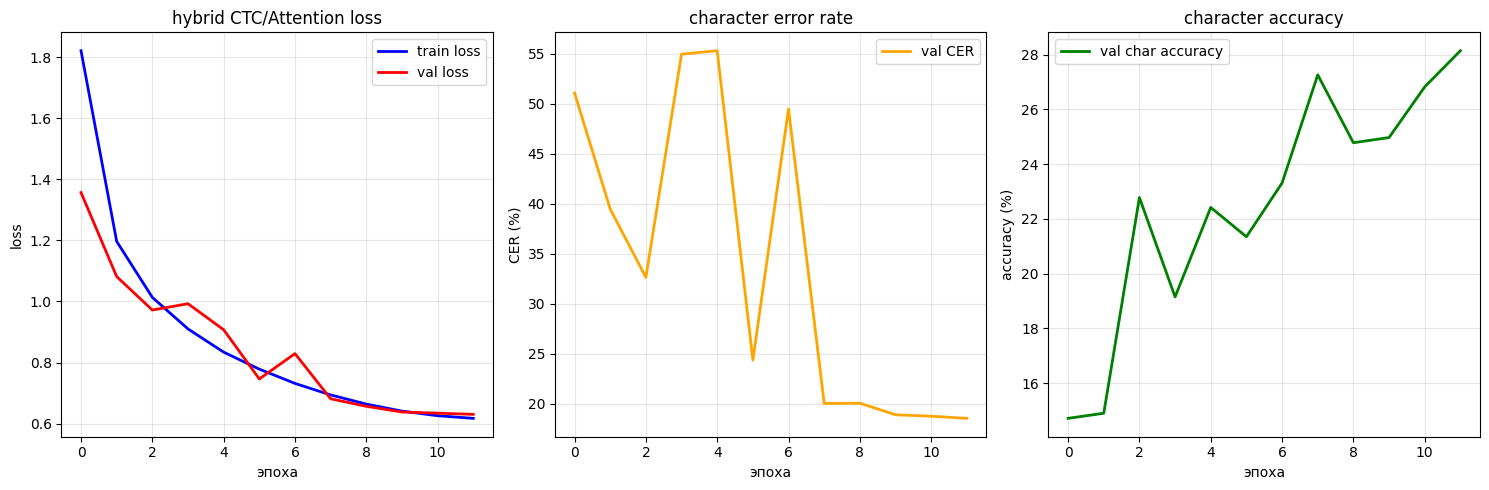

обучение завершено
лучший val loss: 0.6301
лучший val CER: 18.53%
character accuracy: 28.15%


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import soundfile as sf
import librosa
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import random
import math

class HybridConfig:
    SAMPLE_RATE = 16000
    MAX_AUDIO_LENGTH = 3.0
    TRAIN_FRACTION = 0.25  
    
    # encoder
    AUDIO_DIM = 80
    ENCODER_HIDDEN_DIM = 192
    ENCODER_LAYERS = 4  
    
    # decoder  
    DECODER_HIDDEN_DIM = 192
    DECODER_LAYERS = 2
    ATTENTION_DIM = 128
    
    # training
    BATCH_SIZE = 24  
    NUM_EPOCHS = 12
    LEARNING_RATE = 8e-4
    DROPOUT = 0.5
    WEIGHT_DECAY = 1e-4
    
    # hybrid weights
    CTC_WEIGHT = 0.4
    ATTENTION_WEIGHT = 0.6

config = HybridConfig()

class RNNTVocabulary:
    def __init__(self):
        self.char_to_idx = {
            '<pad>': 0, '<sos>': 1, '<eos>': 2, ' ': 3,
            'а': 4, 'б': 5, 'в': 6, 'г': 7, 'д': 8, 'е': 9, 'ё': 10, 'ж': 11,
            'з': 12, 'и': 13, 'й': 14, 'к': 15, 'л': 16, 'м': 17, 'н': 18,
            'о': 19, 'п': 20, 'р': 21, 'с': 22, 'т': 23, 'у': 24, 'ф': 25,
            'х': 26, 'ц': 27, 'ч': 28, 'ш': 29, 'щ': 30, 'ъ': 31, 'ы': 32,
            'ь': 33, 'э': 34, 'ю': 35, 'я': 36,
            '0': 37, '1': 38, '2': 39, '3': 40, '4': 41, '5': 42, '6': 43,
            '7': 44, '8': 45, '9': 46, '!': 47, '?': 48, ',': 49, '.': 50,
            '-': 51, ':': 52, ';': 53, '(': 54, ')': 55, '"': 56, "'": 57
        }
        self.idx_to_char = {v: k for k, v in self.char_to_idx.items()}
        self.vocab_size = len(self.char_to_idx)
        print(f"RNN-vocabulary создан: {self.vocab_size} токенов")
    
    def text_to_indices(self, text):
        indices = [1]  
        for char in text.lower():
            if char in self.char_to_idx:
                indices.append(self.char_to_idx[char])
        indices.append(2)  
        return indices
    
    def indices_to_text(self, indices):
        text = []
        for idx in indices:
            if idx == 2:  
                break
            if idx in self.idx_to_char and idx not in [0, 1]: 
                text.append(self.idx_to_char[idx])
        return ''.join(text)

class RNNTDataset(Dataset):
    def __init__(self, df, vocabulary, max_audio_length=3.0):
        self.df = df.reset_index(drop=True)
        self.vocab = vocabulary
        self.max_audio_length = max_audio_length
        self.sample_rate = config.SAMPLE_RATE
        self.max_samples = int(max_audio_length * self.sample_rate)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        audio_path = row['audio_path']
        text_path = row['text_path']
        
        try:
            audio, sr = sf.read(audio_path)
            if sr != self.sample_rate:
                audio = librosa.resample(audio, orig_sr=sr, target_sr=self.sample_rate)
        except Exception as e:
            print(f"oшибка загрузки аудио {audio_path}: {e}")
            audio = np.zeros(self.max_samples, dtype=np.float32)
        
        if len(audio) > self.max_samples:
            audio = audio[:self.max_samples]
        else:
            audio = np.pad(audio, (0, self.max_samples - len(audio)), mode='constant')
        
        try:
            with open(text_path, 'r', encoding='utf-8') as f:
                text = f.read().strip()
        except Exception as e:
            print(f"oшибка загрузки текста {text_path}: {e}")
            text = ""
        
        tokens = self.vocab.text_to_indices(text)
        
        return {
            'audio': audio.astype(np.float32),
            'tokens': tokens,
            'text': text,
            'audio_length': len(audio)
        }

def rnnt_collate_fn(batch):
    audios = torch.stack([torch.from_numpy(item['audio']) for item in batch])
    texts = [item['tokens'] for item in batch]
    raw_texts = [item['text'] for item in batch]
    audio_lengths = torch.tensor([item['audio_length'] for item in batch])
    
    max_text_len = max(len(t) for t in texts)
    text_tensor = torch.zeros(len(texts), max_text_len, dtype=torch.long)
    text_lengths = torch.tensor([len(t) for t in texts])
    
    for i, text in enumerate(texts):
        text_tensor[i, :len(text)] = torch.tensor(text, dtype=torch.long)
    
    return {
        'audios': audios,
        'texts': text_tensor,
        'text_lengths': text_lengths,
        'audio_lengths': audio_lengths,
        'raw_texts': raw_texts
    }

class HybridAudioEncoder(nn.Module):
    def __init__(self, input_dim=1, feature_dim=80, hidden_dim=192):
        super().__init__()
        
        self.conv_blocks = nn.Sequential(
            nn.Conv1d(input_dim, 64, kernel_size=10, stride=5, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Conv1d(64, 96, kernel_size=8, stride=4, padding=2),
            nn.BatchNorm1d(96),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Conv1d(96, feature_dim, kernel_size=5, stride=4, padding=1),
            nn.BatchNorm1d(feature_dim),
            nn.ReLU(),
        )
        
        self.pool = nn.AvgPool1d(kernel_size=2, stride=2)
        self.projection = nn.Linear(feature_dim, hidden_dim)
        
    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(1)
        
        x = self.conv_blocks(x)
        x = self.pool(x)
        x = x.transpose(1, 2)
        x = self.projection(x)
        return x

class HybridEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=4, dropout=0.2):
        super().__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True  
        )
        
        self.projection = nn.Linear(hidden_dim * 2, hidden_dim)
        
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.projection(x)  
        return x

class BahdanauAttention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim=128):
        super().__init__()
        self.W = nn.Linear(encoder_dim, attention_dim)
        self.U = nn.Linear(decoder_dim, attention_dim)
        self.v = nn.Linear(attention_dim, 1)
        
    def forward(self, decoder_hidden, encoder_outputs):
        decoder_hidden = decoder_hidden.unsqueeze(1)
        scores = self.v(torch.tanh(
            self.W(encoder_outputs) + self.U(decoder_hidden)
        ))
        
        attn_weights = F.softmax(scores, dim=1)
        context = torch.sum(attn_weights * encoder_outputs, dim=1)
        
        return context, attn_weights.squeeze(-1)

class AttentionDecoder(nn.Module):
    def __init__(self, vocab_size, encoder_dim, decoder_dim, num_layers=2, dropout=0.2):
        super().__init__()
        self.vocab_size = vocab_size
        self.decoder_dim = decoder_dim
        
        self.embedding = nn.Embedding(vocab_size, decoder_dim, padding_idx=0)
        self.attention = BahdanauAttention(encoder_dim, decoder_dim)
        
        self.lstm = nn.LSTM(
            input_size=decoder_dim + encoder_dim,
            hidden_size=decoder_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        
        self.output_layer = nn.Linear(decoder_dim + encoder_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, encoder_outputs, targets=None, max_length=100):
        batch_size = encoder_outputs.size(0)
        
        hidden = None
        input_token = torch.full((batch_size,), 1, device=encoder_outputs.device)
        outputs = []
        
        if targets is not None:
            for t in range(targets.size(1) - 1):
                output, hidden = self._step(input_token, hidden, encoder_outputs)
                outputs.append(output)
                input_token = targets[:, t + 1]
        else:
            for t in range(max_length):
                output, hidden = self._step(input_token, hidden, encoder_outputs)
                outputs.append(output)
                
                input_token = torch.argmax(output, dim=-1)
                if (input_token == 2).all():
                    break
        
        return torch.stack(outputs, dim=1)
    
    def _step(self, input_token, hidden, encoder_outputs):
        embedded = self.embedding(input_token)
        
        if hidden is None:
            context = torch.zeros(encoder_outputs.size(0), encoder_outputs.size(2), device=encoder_outputs.device)
        else:
            decoder_hidden = hidden[0][-1]
            context, _ = self.attention(decoder_hidden, encoder_outputs)
        
        lstm_input = torch.cat([embedded, context], dim=-1).unsqueeze(1)
        lstm_out, hidden = self.lstm(lstm_input, hidden)
        lstm_out = lstm_out.squeeze(1)
        
        output_input = torch.cat([lstm_out, context], dim=-1)
        output = self.output_layer(output_input)
        
        return output, hidden

class HybridCTCAttention(nn.Module):
    def __init__(self, config, vocab_size):
        super().__init__()
        self.config = config
        self.vocab_size = vocab_size
        
        self.audio_encoder = HybridAudioEncoder(
            input_dim=1, 
            feature_dim=config.AUDIO_DIM,
            hidden_dim=config.ENCODER_HIDDEN_DIM
        )
        
        self.encoder = HybridEncoder(
            input_dim=config.ENCODER_HIDDEN_DIM,
            hidden_dim=config.ENCODER_HIDDEN_DIM,
            num_layers=config.ENCODER_LAYERS,
            dropout=config.DROPOUT
        )
        
        self.ctc_head = nn.Linear(config.ENCODER_HIDDEN_DIM, vocab_size)
        self.attention_decoder = AttentionDecoder(
            vocab_size=vocab_size,
            encoder_dim=config.ENCODER_HIDDEN_DIM,
            decoder_dim=config.DECODER_HIDDEN_DIM,
            num_layers=config.DECODER_LAYERS,
            dropout=config.DROPOUT
        )
        
    def forward(self, audio_input, text_input=None):
        audio_features = self.audio_encoder(audio_input)
        encoder_out = self.encoder(audio_features)
        
        ctc_logits = self.ctc_head(encoder_out)
        
        if text_input is not None:
            attn_logits = self.attention_decoder(encoder_out, text_input)
            return ctc_logits, attn_logits, encoder_out.size(1)
        else:
            return ctc_logits
    
    def decode(self, audio_input, method='attention', max_length=100):
        self.eval()
        with torch.no_grad():
            audio_features = self.audio_encoder(audio_input)
            encoder_out = self.encoder(audio_features)
            
            if method == 'ctc':
                ctc_logits = self.ctc_head(encoder_out)
                ctc_probs = F.softmax(ctc_logits, dim=-1)
                predictions = torch.argmax(ctc_probs, dim=-1)
                
                decoded = []
                for seq in predictions:
                    chars = []
                    prev_char = None
                    for char_idx in seq:
                        char_idx = char_idx.item()
                        if char_idx != 0 and char_idx != prev_char:
                            if char_idx != 2:
                                chars.append(char_idx)
                        prev_char = char_idx
                    decoded.append(chars)
                return decoded
                
            else:
                attn_logits = self.attention_decoder(encoder_out, max_length=max_length)
                predictions = torch.argmax(attn_logits, dim=-1)
                return [seq.tolist() for seq in predictions]

class HybridLoss(nn.Module):
    def __init__(self, ctc_weight=0.4, blank=0):
        super().__init__()
        self.ctc_weight = ctc_weight
        self.attention_weight = 1.0 - ctc_weight
        self.blank = blank
        
    def forward(self, ctc_logits, attn_logits, targets, input_lengths, target_lengths):
        ctc_log_probs = F.log_softmax(ctc_logits, dim=-1)
        
        max_input_len = ctc_log_probs.size(1)
        input_lengths = torch.clamp(input_lengths, max=max_input_len)
        
        ctc_loss = F.ctc_loss(
            ctc_log_probs.transpose(0, 1),
            targets,
            input_lengths,
            target_lengths,
            blank=self.blank,
            zero_infinity=True
        )
        
        attn_loss = F.cross_entropy(
            attn_logits.reshape(-1, attn_logits.size(-1)),
            targets[:, 1:].reshape(-1),
            ignore_index=0
        )
        
        total_loss = (self.ctc_weight * ctc_loss + 
                     self.attention_weight * attn_loss)
        
        return total_loss, ctc_loss, attn_loss

class HybridTrainer:
    def __init__(self, model, vocab, device):
        self.model = model
        self.vocab = vocab
        self.device = device
        self.best_val_loss = float('inf')
        self.best_val_cer = 100.0
        
    def train(self, train_loader, val_loader, num_epochs=12, lr=8e-4):
        optimizer = optim.AdamW(
            self.model.parameters(), 
            lr=lr,
            weight_decay=config.WEIGHT_DECAY
        )
        
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
        loss_fn = HybridLoss(ctc_weight=config.CTC_WEIGHT)
        
        train_losses, val_losses, val_cers, val_accs = [], [], [], []
        
        print("начало обучения")
        print(f"параметры модели: {sum(p.numel() for p in self.model.parameters()):,}")
        
        for epoch in range(num_epochs):
            print(f"\nэпоха {epoch+1}/{num_epochs}")
            print("=" * 55)
            
            train_loss = self._train_epoch(optimizer, loss_fn, train_loader)
            train_losses.append(train_loss)
            
            val_loss, val_cer, val_acc = self._validate_epoch(loss_fn, val_loader)
            val_losses.append(val_loss)
            val_cers.append(val_cer)
            val_accs.append(val_acc)
            
            scheduler.step()
            
            print(f"train loss: {train_loss:.4f}, val loss: {val_loss:.4f}")
            print(f"val CER: {val_cer:.2f}%, val char accuracy: {val_acc:.2f}%")
            print(f"learning rate: {scheduler.get_last_lr()[0]:.2e}")
            
            if val_cer < self.best_val_cer:
                self.best_val_cer = val_cer
                self.best_val_loss = val_loss
                torch.save(self.model.state_dict(), 'best_hybrid_model2.pth')
                print(f"модель сохранена! CER: {val_cer:.2f}%")
            
            self._test_decoding(val_loader)
        
        return train_losses, val_losses, val_cers, val_accs
    
    def _train_epoch(self, optimizer, loss_fn, dataloader):
        self.model.train()
        total_loss = 0.0  
        
        progress_bar = tqdm(dataloader, desc="Training")
        for batch_idx, batch in enumerate(progress_bar):
            audios = batch['audios'].to(self.device, non_blocking=True)
            texts = batch['texts'].to(self.device, non_blocking=True)
            text_lengths = batch['text_lengths'].to(self.device, non_blocking=True)
            audio_lengths = batch['audio_lengths'].to(self.device, non_blocking=True)
            
            optimizer.zero_grad()
            
            ctc_logits, attn_logits, seq_len = self.model(audios, texts)
            ctc_input_lengths = self._calculate_ctc_lengths(audio_lengths, seq_len)
            
            loss, ctc_loss, attn_loss = loss_fn(
                ctc_logits, attn_logits, texts, ctc_input_lengths, text_lengths
            )
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 0.5)
            optimizer.step()
            
            total_loss += loss.item() 
            
            if batch_idx % 50 == 0:
                avg_loss = total_loss / (batch_idx + 1)
                progress_bar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'ctc': f'{ctc_loss.item():.4f}',
                    'attn': f'{attn_loss.item():.4f}',
                    'avg': f'{avg_loss:.4f}'
                })
        
        return total_loss / len(dataloader)
    
    def _calculate_ctc_lengths(self, audio_lengths, seq_len):
        compression_factor = 160
        ctc_lengths = (audio_lengths / compression_factor).long()
        ctc_lengths = torch.clamp(ctc_lengths, max=seq_len)
        return ctc_lengths
    
    def _validate_epoch(self, loss_fn, dataloader):
        self.model.eval()
        total_loss = 0.0
        total_cer = 0.0
        total_char_accuracy = 0.0
        total_samples = 0
        
        with torch.no_grad():
            for batch in tqdm(dataloader, desc="Validation"):
                audios = batch['audios'].to(self.device)
                texts = batch['texts'].to(self.device)
                text_lengths = batch['text_lengths'].to(self.device)
                audio_lengths = batch['audio_lengths'].to(self.device)
                
                ctc_logits, attn_logits, seq_len = self.model(audios, texts)
                ctc_input_lengths = self._calculate_ctc_lengths(audio_lengths, seq_len)
                
                loss, ctc_loss, attn_loss = loss_fn(
                    ctc_logits, attn_logits, texts, ctc_input_lengths, text_lengths
                )
                
                total_loss += loss.item()
                
                for i in range(min(5, len(audios))):
                    original = batch['raw_texts'][i]
                    predicted_indices = self.model.decode(audios[i:i+1], method='attention')
                    predicted_text = self.vocab.indices_to_text(predicted_indices[0])
                    
                    if predicted_text:
                        cer = self._calculate_cer(original, predicted_text)
                        char_acc = self._calculate_char_accuracy(original, predicted_text)
                        total_cer += cer
                        total_char_accuracy += char_acc
                        total_samples += 1
        
        avg_loss = total_loss / len(dataloader)
        avg_cer = (total_cer / total_samples) * 100 if total_samples > 0 else 100
        avg_char_acc = (total_char_accuracy / total_samples) * 100 if total_samples > 0 else 0
        return avg_loss, avg_cer, avg_char_acc
    
    def _calculate_cer(self, original, predicted):
        from difflib import SequenceMatcher
        return 1 - SequenceMatcher(None, original.lower(), predicted.lower()).ratio()
    
    def _calculate_char_accuracy(self, original, predicted):
        original = original.lower().replace(' ', '')
        predicted = predicted.lower().replace(' ', '')
        
        if not original or not predicted:
            return 0.0
            
        matches = 0
        min_len = min(len(original), len(predicted))
        
        for i in range(min_len):
            if original[i] == predicted[i]:
                matches += 1
                
        return matches / len(original) if original else 0.0
    
    def _test_decoding(self, dataloader, num_examples=3):
        self.model.eval()
        with torch.no_grad():
            batch = next(iter(dataloader))
            audios = batch['audios'].to(self.device)
            
            print("=" * 55)
            for i in range(min(num_examples, len(audios))):
                original = batch['raw_texts'][i]
                
                ctc_indices = self.model.decode(audios[i:i+1], method='ctc')
                ctc_text = self.vocab.indices_to_text(ctc_indices[0])
                
                attn_indices = self.model.decode(audios[i:i+1], method='attention')
                attn_text = self.vocab.indices_to_text(attn_indices[0])
                
                char_acc = self._calculate_char_accuracy(original, attn_text) * 100
                
                print(f"оригинал:   {original}")
                print(f"CTC:        {ctc_text if ctc_text else '[пусто]'}")
                print(f"attention:  {attn_text if attn_text else '[пусто]'} (Acc: {char_acc:.1f}%)")

def main():
    torch.cuda.empty_cache()
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"устройство: {device}")
    
    clean_df = pd.read_csv('clean_dataset.csv')
    
    train_size = int(len(clean_df) * config.TRAIN_FRACTION)
    train_df = clean_df[:train_size]
    val_df = clean_df[train_size:train_size + 2000]
    
    print(f"размеры данных:")
    print(f"train: {len(train_df):,} samples")
    print(f"val: {len(val_df):,} samples")
    
    vocab = RNNTVocabulary()
    train_dataset = RNNTDataset(train_df, vocab, max_audio_length=config.MAX_AUDIO_LENGTH)
    val_dataset = RNNTDataset(val_df, vocab, max_audio_length=config.MAX_AUDIO_LENGTH)
    
    train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, 
                             num_workers=0, collate_fn=rnnt_collate_fn, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False, 
                           num_workers=0, collate_fn=rnnt_collate_fn, pin_memory=True)
    
    model = HybridCTCAttention(config, vocab.vocab_size).to(device)
    
    print(f"параметры модели: {sum(p.numel() for p in model.parameters()):,}")
    
    trainer = HybridTrainer(model, vocab, device)
    train_losses, val_losses, val_cers, val_accs = trainer.train(train_loader, val_loader)
    
    torch.save(model.state_dict(), 'final_hybrid_model2.pth')
    print(f"модель сохранена! final_hybrid_model2.pth")
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='train loss', linewidth=2, color='blue')
    plt.plot(val_losses, label='val loss', linewidth=2, color='red')
    plt.xlabel('эпоха')
    plt.ylabel('loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.title('hybrid CTC/Attention loss')
    
    plt.subplot(1, 3, 2)
    plt.plot(val_cers, label='val CER', linewidth=2, color='orange')
    plt.xlabel('эпоха')
    plt.ylabel('CER (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.title('character error rate')
    
    plt.subplot(1, 3, 3)
    plt.plot(val_accs, label='val char accuracy', linewidth=2, color='green')
    plt.xlabel('эпоха')
    plt.ylabel('accuracy (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.title('character accuracy')
    
    plt.tight_layout()
    plt.savefig('training_results_upgrade.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"обучение завершено")
    print(f"лучший val loss: {trainer.best_val_loss:.4f}")
    print(f"лучший val CER: {trainer.best_val_cer:.2f}%")
    print(f"character accuracy: {val_accs[-1]:.2f}%")

if __name__ == "__main__":
    main()

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import soundfile as sf
import librosa
import os

class HybridConfig:
    SAMPLE_RATE = 16000
    MAX_AUDIO_LENGTH = 5.0  
    
    # encoder
    AUDIO_DIM = 80
    ENCODER_HIDDEN_DIM = 192
    ENCODER_LAYERS = 4
    
    # decoder  
    DECODER_HIDDEN_DIM = 192
    DECODER_LAYERS = 2
    ATTENTION_DIM = 128
    
    # training
    DROPOUT = 0.5

config = HybridConfig()

class RNNTVocabulary:
    def __init__(self):
        self.char_to_idx = {
            '<pad>': 0, '<sos>': 1, '<eos>': 2, ' ': 3,
            'а': 4, 'б': 5, 'в': 6, 'г': 7, 'д': 8, 'е': 9, 'ё': 10, 'ж': 11,
            'з': 12, 'и': 13, 'й': 14, 'к': 15, 'л': 16, 'м': 17, 'н': 18,
            'о': 19, 'п': 20, 'р': 21, 'с': 22, 'т': 23, 'у': 24, 'ф': 25,
            'х': 26, 'ц': 27, 'ч': 28, 'ш': 29, 'щ': 30, 'ъ': 31, 'ы': 32,
            'ь': 33, 'э': 34, 'ю': 35, 'я': 36,
            '0': 37, '1': 38, '2': 39, '3': 40, '4': 41, '5': 42, '6': 43,
            '7': 44, '8': 45, '9': 46, '!': 47, '?': 48, ',': 49, '.': 50,
            '-': 51, ':': 52, ';': 53, '(': 54, ')': 55, '"': 56, "'": 57
        }
        self.idx_to_char = {v: k for k, v in self.char_to_idx.items()}
        self.vocab_size = len(self.char_to_idx)
    
    def indices_to_text(self, indices):
        text = []
        for idx in indices:
            if idx == 2:  
                break
            if idx in self.idx_to_char and idx not in [0, 1]: 
                text.append(self.idx_to_char[idx])
        return ''.join(text)

class HybridAudioEncoder(nn.Module):
    def __init__(self, input_dim=1, feature_dim=80, hidden_dim=192):
        super().__init__()
        self.conv_blocks = nn.Sequential(
            nn.Conv1d(input_dim, 64, kernel_size=10, stride=5, padding=3),
            nn.BatchNorm1d(64), nn.ReLU(), nn.Dropout(0.2),
            nn.Conv1d(64, 96, kernel_size=8, stride=4, padding=2),
            nn.BatchNorm1d(96), nn.ReLU(), nn.Dropout(0.2),
            nn.Conv1d(96, feature_dim, kernel_size=5, stride=4, padding=1),
            nn.BatchNorm1d(feature_dim), nn.ReLU(),
        )
        self.pool = nn.AvgPool1d(kernel_size=2, stride=2)
        self.projection = nn.Linear(feature_dim, hidden_dim)
        
    def forward(self, x):
        if x.dim() == 2: x = x.unsqueeze(1)
        x = self.conv_blocks(x)
        x = self.pool(x)
        x = x.transpose(1, 2)
        x = self.projection(x)
        return x

class HybridEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=4, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim,
                          num_layers=num_layers, batch_first=True,
                          dropout=dropout, bidirectional=True)
        self.projection = nn.Linear(hidden_dim * 2, hidden_dim)
        
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.projection(x)
        return x

class BahdanauAttention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim=128):
        super().__init__()
        self.W = nn.Linear(encoder_dim, attention_dim)
        self.U = nn.Linear(decoder_dim, attention_dim)
        self.v = nn.Linear(attention_dim, 1)
        
    def forward(self, decoder_hidden, encoder_outputs):
        decoder_hidden = decoder_hidden.unsqueeze(1)
        scores = self.v(torch.tanh(self.W(encoder_outputs) + self.U(decoder_hidden)))
        attn_weights = F.softmax(scores, dim=1)
        context = torch.sum(attn_weights * encoder_outputs, dim=1)
        return context, attn_weights.squeeze(-1)

class AttentionDecoder(nn.Module):
    def __init__(self, vocab_size, encoder_dim, decoder_dim, num_layers=2, dropout=0.2):
        super().__init__()
        self.vocab_size = vocab_size
        self.decoder_dim = decoder_dim
        self.embedding = nn.Embedding(vocab_size, decoder_dim, padding_idx=0)
        self.attention = BahdanauAttention(encoder_dim, decoder_dim)
        self.lstm = nn.LSTM(input_size=decoder_dim + encoder_dim, hidden_size=decoder_dim,
                          num_layers=num_layers, batch_first=True, dropout=dropout)
        self.output_layer = nn.Linear(decoder_dim + encoder_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, encoder_outputs, targets=None, max_length=100):
        batch_size = encoder_outputs.size(0)
        hidden, input_token = None, torch.full((batch_size,), 1, device=encoder_outputs.device)
        outputs = []
        
        if targets is not None:
            for t in range(targets.size(1) - 1):
                output, hidden = self._step(input_token, hidden, encoder_outputs)
                outputs.append(output)
                input_token = targets[:, t + 1]
        else:
            for t in range(max_length):
                output, hidden = self._step(input_token, hidden, encoder_outputs)
                outputs.append(output)
                input_token = torch.argmax(output, dim=-1)
                if (input_token == 2).all(): break
        
        return torch.stack(outputs, dim=1)
    
    def _step(self, input_token, hidden, encoder_outputs):
        embedded = self.embedding(input_token)
        if hidden is None:
            context = torch.zeros(encoder_outputs.size(0), encoder_outputs.size(2), device=encoder_outputs.device)
        else:
            decoder_hidden = hidden[0][-1]
            context, _ = self.attention(decoder_hidden, encoder_outputs)
        
        lstm_input = torch.cat([embedded, context], dim=-1).unsqueeze(1)
        lstm_out, hidden = self.lstm(lstm_input, hidden)
        lstm_out = lstm_out.squeeze(1)
        output_input = torch.cat([lstm_out, context], dim=-1)
        output = self.output_layer(output_input)
        return output, hidden

class HybridCTCAttention(nn.Module):
    def __init__(self, config, vocab_size):
        super().__init__()
        self.config = config
        self.vocab_size = vocab_size
        self.audio_encoder = HybridAudioEncoder(input_dim=1, feature_dim=config.AUDIO_DIM, hidden_dim=config.ENCODER_HIDDEN_DIM)
        self.encoder = HybridEncoder(input_dim=config.ENCODER_HIDDEN_DIM, hidden_dim=config.ENCODER_HIDDEN_DIM, num_layers=config.ENCODER_LAYERS, dropout=config.DROPOUT)
        self.ctc_head = nn.Linear(config.ENCODER_HIDDEN_DIM, vocab_size)
        self.attention_decoder = AttentionDecoder(vocab_size=vocab_size, encoder_dim=config.ENCODER_HIDDEN_DIM, decoder_dim=config.DECODER_HIDDEN_DIM, num_layers=config.DECODER_LAYERS, dropout=config.DROPOUT)
        
    def forward(self, audio_input, text_input=None):
        audio_features = self.audio_encoder(audio_input)
        encoder_out = self.encoder(audio_features)
        ctc_logits = self.ctc_head(encoder_out)
        if text_input is not None:
            attn_logits = self.attention_decoder(encoder_out, text_input)
            return ctc_logits, attn_logits, encoder_out.size(1)
        else:
            return ctc_logits
    
    def decode(self, audio_input, method='attention', max_length=150):  
        self.eval()
        with torch.no_grad():
            audio_features = self.audio_encoder(audio_input)
            encoder_out = self.encoder(audio_features)
            
            if method == 'ctc':
                ctc_logits = self.ctc_head(encoder_out)
                ctc_probs = F.softmax(ctc_logits, dim=-1)
                predictions = torch.argmax(ctc_probs, dim=-1)
                
                decoded = []
                for seq in predictions:
                    chars = []
                    prev_char = None
                    for char_idx in seq:
                        char_idx = char_idx.item()
                        if char_idx != 0 and char_idx != prev_char:
                            if char_idx != 2:
                                chars.append(char_idx)
                        prev_char = char_idx
                    decoded.append(chars)
                return decoded
                
            else:
                attn_logits = self.attention_decoder(encoder_out, max_length=max_length)
                predictions = torch.argmax(attn_logits, dim=-1)
                return [seq.tolist() for seq in predictions]

def test_single_audio(model, vocab, audio_path, device):
    
    print(f"тестируем аудио: {os.path.basename(audio_path)}")
    
    try:
        audio, sr = sf.read(audio_path)
        print(f"исходное аудио: SR={sr}, длина={len(audio)/sr:.2f} сек")
        
        if sr != config.SAMPLE_RATE:
            audio = librosa.resample(audio, orig_sr=sr, target_sr=config.SAMPLE_RATE)
            print(f"ресемплинг до {config.SAMPLE_RATE} Hz")
        
        max_samples = int(config.MAX_AUDIO_LENGTH * config.SAMPLE_RATE)
        if len(audio) > max_samples:
            audio = audio[:max_samples]
            print(f"обрезано до {config.MAX_AUDIO_LENGTH} сек")
        else:
            audio = np.pad(audio, (0, max_samples - len(audio)), mode='constant')
            print(f"дополнено до {config.MAX_AUDIO_LENGTH} сек")
            
    except Exception as e:
        print(f"ошибка загрузки аудио: {e}")
        return
    
    audio_tensor = torch.from_numpy(audio.astype(np.float32)).unsqueeze(0).to(device)
    print("аудио подготовлено для модели")
        
    ctc_indices = model.decode(audio_tensor, method='ctc')
    ctc_text = vocab.indices_to_text(ctc_indices[0])
    
    attn_indices = model.decode(audio_tensor, method='attention')
    attn_text = vocab.indices_to_text(attn_indices[0])
    
    print("=" * 55)
    print(f"CTC:         {ctc_text if ctc_text else '[пусто]'}")
    print(f"Attention:   {attn_text if attn_text else '[пусто]'}")
    print("=" * 55)

def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_path = 'final_hybrid_model2.pth'
    audio_path = '/home/grigory/ML/diploms/kirillov/radio_pspeech_sample_manifest/radio_v4_add/e/00/5043a0b9f1a7.opus'
    
    print(f"устройство: {device}")
    print(f"модель: {model_path}")
    print(f"аудио: {audio_path}")
    
    if not os.path.exists(model_path):
        print(f"модель {model_path} не найдена!")
        return
        
    if not os.path.exists(audio_path):
        print(f"аудио файл {audio_path} не найден!")
        return
    
    vocab = RNNTVocabulary()
    model = HybridCTCAttention(config, vocab.vocab_size).to(device)
    
    print("загрузка модели")
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
        print("модель загружена успешно!")
    except Exception as e:
        print(f"ошибка загрузки модели: {e}")
        return
    
    print("=" * 55)
    test_single_audio(model, vocab, audio_path, device)

if __name__ == "__main__":
    main()

устройство: cuda
модель: final_hybrid_model2.pth
аудио: /home/grigory/ML/diploms/kirillov/radio_pspeech_sample_manifest/radio_v4_add/e/00/5043a0b9f1a7.opus
загрузка модели
модель загружена успешно!
тестируем аудио: 5043a0b9f1a7.opus
исходное аудио: SR=16000, длина=4.56 сек
дополнено до 5.0 сек
аудио подготовлено для модели
CTC:         ино дли с которых боществой дума работать и в настаяща время
Attention:   о многие скокорых большинство думаю работать и в настоящее время
